Install dependencies

In [1]:
!pip install numpy==1.26.0
!pip install scikit-surprise --quiet
!pip install emoji --quiet

print('Installed scikit-surprise')


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 18.4 MB/s eta 0:00:00
Installed scikit-surprise


Load MovieLens 100k dataset using Surprise's built-in loader

In [2]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
import pandas as pd
import numpy as np

data = Dataset.load_builtin('ml-100k')
raw_ratings = data.raw_ratings[:5]
print('Sample raw ratings (first 5):', raw_ratings)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
print('Trainset size (n_ratings):', trainset.n_ratings)
print('Testset length:', len(testset))


Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
Sample raw ratings (first 5): [('196', '242', 3.0, '881250949'), ('186', '302', 3.0, '891717742'), ('22', '377', 1.0, '878887116'), ('244', '51', 2.0, '880606923'), ('166', '346', 1.0, '886397596')]
Trainset size (n_ratings): 80000
Testset length: 20000


Train baseline algorithms and evaluate

In [3]:
from surprise import SVD, KNNBasic, NMF
from surprise import accuracy
from surprise.model_selection import cross_validate

algorithms = {
    'SVD': SVD(random_state=42),
    'NMF': NMF(random_state=42),
    'KNNBasic_user': KNNBasic(sim_options={'user_based': True}),
}

results = []
for name, algo in algorithms.items():
    print('Running:', name)
    algo.fit(trainset)
    preds = algo.test(testset)
    rmse = accuracy.rmse(preds, verbose=False)
    mae = accuracy.mae(preds, verbose=False)

    cv = cross_validate(algo, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    cv_rmse = np.mean(cv['test_rmse'])
    cv_mae = np.mean(cv['test_mae'])
    results.append({'Algorithm': name, 'RMSE_test': rmse, 'MAE_test': mae, 'CV_RMSE': cv_rmse, 'CV_MAE': cv_mae})

results_df = pd.DataFrame(results)
results_df


Running: SVD
Running: NMF
Running: KNNBasic_user
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,Algorithm,RMSE_test,MAE_test,CV_RMSE,CV_MAE
0,SVD,0.935171,0.737509,0.945559,0.746140
1,NMF,0.959408,0.753335,0.977011,0.766882
2,KNNBasic_user,0.980151,0.772692,0.988391,0.781122


from matplotlib import pyplot as plt
results_df['RMSE_test'].plot(kind='hist', bins=20, title='RMSE_test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['MAE_test'].plot(kind='hist', bins=20, title='MAE_test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['CV_RMSE'].plot(kind='hist', bins=20, title='CV_RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['CV_MAE'].plot(kind='hist', bins=20, title='CV_MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('Algorithm').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='RMSE_test', y='MAE_test', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='MAE_test', y='CV_RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='CV_RMSE', y='CV_MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RMSE_test']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RMSE_test'}, axis=1)
              .sort_values('RMSE_test', ascending=True))
  xs = counted['RMSE_test']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('RMSE_test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Algorithm')):
  _plot_series(series, series_name, i)
  fig.legend(title='Algorithm', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE_test')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MAE_test']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MAE_test'}, axis=1)
              .sort_values('MAE_test', ascending=True))
  xs = counted['MAE_test']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('MAE_test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Algorithm')):
  _plot_series(series, series_name, i)
  fig.legend(title='Algorithm', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE_test')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['CV_RMSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'CV_RMSE'}, axis=1)
              .sort_values('CV_RMSE', ascending=True))
  xs = counted['CV_RMSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('CV_RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Algorithm')):
  _plot_series(series, series_name, i)
  fig.legend(title='Algorithm', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CV_RMSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['CV_MAE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'CV_MAE'}, axis=1)
              .sort_values('CV_MAE', ascending=True))
  xs = counted['CV_MAE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('CV_MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Algorithm')):
  _plot_series(series, series_name, i)
  fig.legend(title='Algorithm', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CV_MAE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results_df['RMSE_test'].plot(kind='line', figsize=(8, 4), title='RMSE_test')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['MAE_test'].plot(kind='line', figsize=(8, 4), title='MAE_test')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['CV_RMSE'].plot(kind='line', figsize=(8, 4), title='CV_RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['CV_MAE'].plot(kind='line', figsize=(8, 4), title='CV_MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Algorithm'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='RMSE_test', y='Algorithm', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Algorithm'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='MAE_test', y='Algorithm', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Algorithm'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='CV_RMSE', y='Algorithm', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Algorithm'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='CV_MAE', y='Algorithm', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

 Grid search to tune hyperparameters for SVD and KNN

In [5]:
from surprise.model_selection import GridSearchCV

param_grid_svd = {
    'n_factors': [20, 50],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.05]
}

gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse','mae'], cv=3, n_jobs=1)
print('Running grid search for SVD (this may take a minute)...')
gs_svd.fit(data)
best_svd_params = gs_svd.best_params['rmse']
best_svd_score = gs_svd.best_score['rmse']
print('Best SVD params (by RMSE):', best_svd_params)

param_grid_knn = {
    'k': [20, 40],
    'sim_options': {'name': ['cosine', 'msd'], 'user_based': [True]}
}
gs_knn = GridSearchCV(KNNBasic, param_grid_knn, measures=['rmse','mae'], cv=3, n_jobs=1)
print('Running grid search for KNN (this may take a minute)...')
gs_knn.fit(data)
best_knn_params = gs_knn.best_params['rmse']
best_knn_score = gs_knn.best_score['rmse']
print('Best KNN params (by RMSE):', best_knn_params)

grid_results = {'SVD_best_params': best_svd_params, 'SVD_best_rmse': best_svd_score,
               'KNN_best_params': best_knn_params, 'KNN_best_rmse': best_knn_score}
import pprint
pprint.pprint(grid_results)


Running grid search for SVD (this may take a minute)...
Best SVD params (by RMSE): {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.05}
Running grid search for KNN (this may take a minute)...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similar

Generate Top-N recommendations and compute Precision@K / Recall@K

In [6]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for (iid, _) in user_ratings[:n]]
    return top_n

def precision_recall_at_k(predictions, k=5, threshold=4.0):
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    mean_precision = np.mean(list(precisions.values()))
    mean_recall = np.mean(list(recalls.values()))
    return mean_precision, mean_recall

best_svd = SVD(**best_svd_params)
best_svd.fit(trainset)
predictions = best_svd.test(testset)
top_n = get_top_n(predictions, n=10)

sample_users = list(top_n.keys())[:5]
top_5_table = {u: top_n[u][:5] for u in sample_users}
import pandas as pd
pd.DataFrame.from_dict(top_5_table, orient='index', columns=[f'Top{i+1}' for i in range(5)])


,Top1,Top2,Top3,Top4,Top5
907,813,79,172,647,185
371,186,210,97,175,55
218,12,654,209,47,42
829,408,190,198,170,124
733,515,922,14,1129,1


Compute Precision@K and Recall@K for best SVD

In [7]:
prec, rec = precision_recall_at_k(predictions, k=5, threshold=4.0)
print(f'Precision@5: {prec:.4f} | Recall@5: {rec:.4f}')

Precision@5: 0.6110 | Recall@5: 0.2212


Plots: RMSE/MAE comparison and Grid-search results

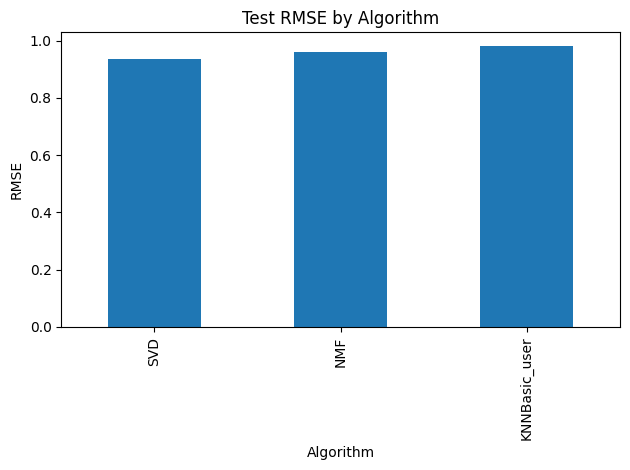

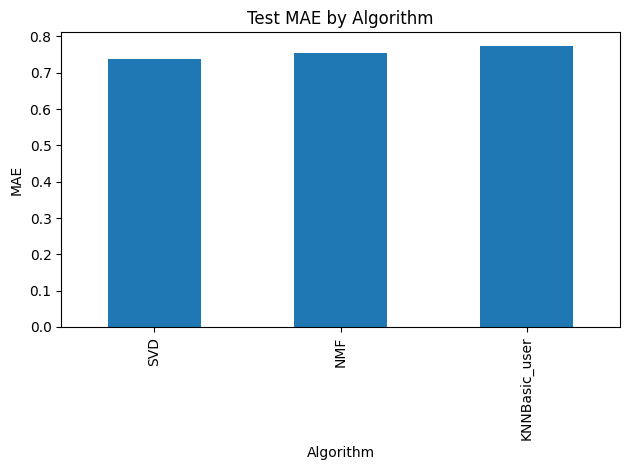

,params,mean_test_rmse,mean_test_mae
0,"{'n_factors': 20, 'lr_all': 0.002, 'reg_all': ...",0.951581,0.754047
1,"{'n_factors': 20, 'lr_all': 0.002, 'reg_all': ...",0.951564,0.754890
2,"{'n_factors': 20, 'lr_all': 0.005, 'reg_all': ...",0.941182,0.743281
3,"{'n_factors': 20, 'lr_all': 0.005, 'reg_all': ...",0.941773,0.745000
4,"{'n_factors': 50, 'lr_all': 0.002, 'reg_all': ...",0.952654,0.754881


In [8]:
import matplotlib.pyplot as plt

results_df_plot = results_df.set_index('Algorithm')

plt.figure()
results_df_plot['RMSE_test'].plot(kind='bar')
plt.title('Test RMSE by Algorithm')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

plt.figure()
results_df_plot['MAE_test'].plot(kind='bar')
plt.title('Test MAE by Algorithm')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()

svd_grid_df = pd.DataFrame(gs_svd.cv_results)
svd_grid_display = svd_grid_df[['params','mean_test_rmse','mean_test_mae']]
svd_grid_display.head()